In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import special_ortho_group
from hisel.select import HSICSelector as Selector

# Linear and non-linear  transformation in high dimension

In [2]:
dim_x = 20
dim_y = 3
dim_z = 5

batch_size = int(1e+4)
minibatch_size = 250
num_of_samples = int(1e+4)
number_of_epochs = 3

In [3]:
transform_tilde = special_ortho_group.rvs(dim_z)[:dim_y]
A = np.random.permutation(np.concatenate((np.eye(dim_z), np.zeros((dim_z, dim_x - dim_z))), axis=1).T).T
transform = transform_tilde @ A

In [4]:
x_samples = np.random.uniform(size=(num_of_samples, dim_x))
tt = np.expand_dims(transform, axis=0)
prey = (tt @ np.expand_dims(np.square(x_samples), axis=2))[:, :, 0]
y_samples = np.random.normal(0, 1e-1, size=prey.shape)  # np.zeros_like(prey)
y_samples[:, 0] += np.sin(2*np.pi*prey[:, 0])
y_samples[:, 1] += np.cos(2*np.pi*prey[:, 1])
y_samples[:, 2] += np.sin(2*np.pi*prey[:, 2])

### Viz of relations between target and features

Becasue of the initial rotation, visual inspection of the relation between features and target does not give insights on which features should be selected

Relation between $y$ and a correct feature

In [5]:
expected_features = np.argsort(np.sum(A, axis=0))[::-1][:dim_z]
# sns.scatterplot(x=x_samples[:, expected_features[0]], y=y_samples[:, 0])

Relation between $y$ and a wrong feature

In [6]:
nonrelevant = set(range(dim_x)).difference(set(expected_features))
featureidx = np.random.choice(list(nonrelevant))
# sns.scatterplot(x=x_samples[:, featureidx], y=y_samples[:, 0])

In [7]:
projector = Selector(x_samples, y_samples)


HSIC feature selection
Feature type of x: FeatureType.CONT
Feature type of y: FeatureType.CONT
Data type of x: float64
Data type of y: float64
Total number of features: 20
Dimensionality of target: 3
Number of x samples: 10000
Number of y samples: 10000


In [8]:
curve = projector.regularization_curve(
    batch_size=batch_size,
    minibatch_size=minibatch_size,
    number_of_epochs=number_of_epochs
)

100%|███████████████████████████████████████| 120/120 [00:00<00:00, 2310.29it/s]


In [9]:
paths = projector.lasso_path()

#### Sorted features by decreasing importance

In [10]:
print(f'Sorted features by decreasing importance: {projector.ordered_features}')

Sorted features by decreasing importance: [16, 15, 5, 14, 19, 8, 3, 10, 0, 18, 17, 1, 9, 4, 6, 2, 13, 7, 12]


### Test selection

In [11]:
expected_features = np.argsort(np.sum(A, axis=0))[::-1][:dim_z]
noise_features = set(range(dim_x)).difference(set(expected_features))
selected_features = np.argsort(paths.iloc[-1, :])[::-1][:dim_z]
print(f'Expected features: {sorted(list(expected_features))}')
print(f'Selected features: {sorted(list(selected_features))}')

Expected features: [5, 14, 15, 16, 19]
Selected features: [5, 14, 15, 16, 19]


## Comparison with sklearn

In [12]:
from sklearn.feature_selection import f_regression, mutual_info_regression

In [13]:
fstats = np.zeros(shape=(dim_x, dim_z), dtype=float)
for i in range(dim_y):
    fstats[:, i], _ = f_regression(x_samples, y_samples[:, i])
fstat = np.sum(fstats, axis=1)
fstat /= np.max(fstat)
f_selection = np.argsort(fstat)[::-1][:dim_z]
print(f'Expected features: {sorted(list(expected_features))}')
print(f'F-selected features: {sorted(f_selection)}')

Expected features: [5, 14, 15, 16, 19]
F-selected features: [5, 14, 15, 16, 18]


In [14]:
mis = np.zeros(shape=(dim_x, dim_z), dtype=float)
for i in range(dim_y):
    mis[:, i] = mutual_info_regression(x_samples, y_samples[:, i])
mi = np.sum(mis, axis=1)
mi /= np.max(mi)
mi_selection = np.argsort(mi)[::-1][:dim_z]
print(f'Expected features: {sorted(list(expected_features))}')
print(f'MI-selected features: {sorted(mi_selection)}')
print(f'mutual information: {mi[mi_selection]}')

Expected features: [5, 14, 15, 16, 19]
MI-selected features: [5, 6, 14, 15, 16]
mutual information: [1.         0.29872739 0.17315844 0.10163843 0.06594454]


## Regularisation curve

#### Cumulative beta

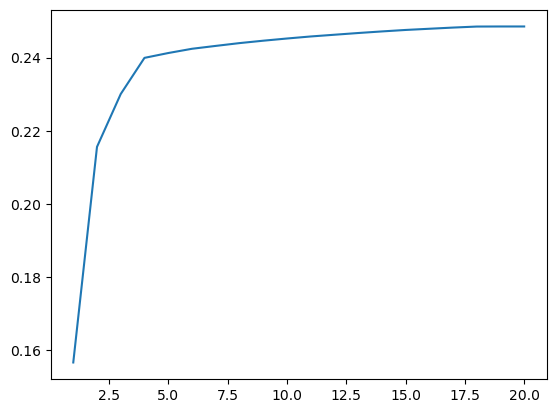

In [15]:
plt.plot(np.arange(1, 1+len(curve)), curve)

#### Absolute beta

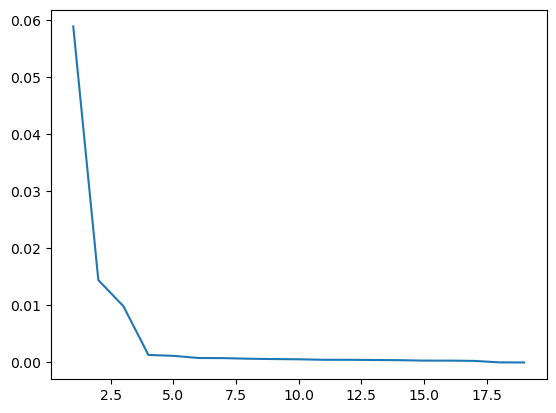

In [16]:
plt.plot(np.arange(1, len(curve)), np.abs(np.diff(curve)))

## Lasso paths

<Axes: >

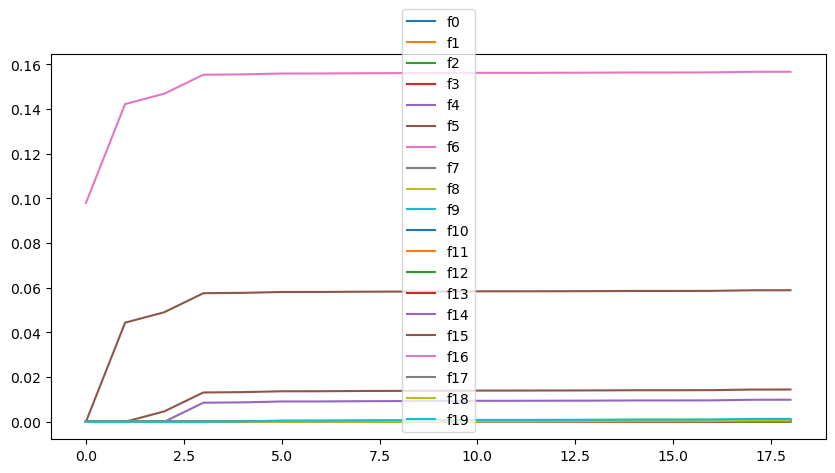

In [17]:
paths.plot(figsize=(10, 5))